# Fixing dependencies in because of version imcompatabilities between tensorflow and gym. 

In [ ]:
# # !pip install keras
# !pip install keras-rl2

## Importing Gym OpenAI

In [1]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [2]:
from keras import backend

In [3]:
import gym 
import random
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt 
import numpy as np
# import keras.backend as K


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

### Here we implement the brute force/Random action sampling as baseline

In [5]:
env = gym.make('CartPole-v0')
states = env.observation_space.shape[0]
actions = env.action_space.n

#### No. of Actions Available are:

Left or right on a 1-D Axis, as in, where to move the cart in order to balance the pole.

In [6]:
actions

2

### Baseline Implementation with random action sampling

Episode:1 Score:17.0
Episode:2 Score:18.0
Episode:3 Score:32.0
Episode:4 Score:43.0
Episode:5 Score:18.0
Episode:6 Score:25.0
Episode:7 Score:17.0
Episode:8 Score:58.0
Episode:9 Score:39.0
Episode:10 Score:18.0


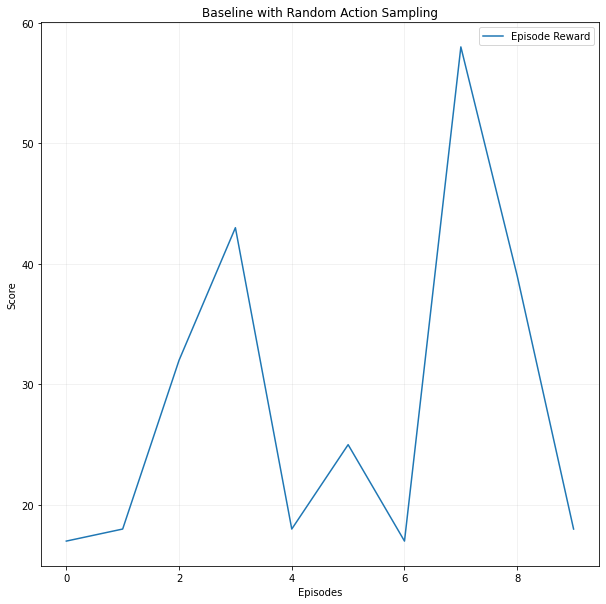

In [7]:
episodes = 10

# episode_list = []
score_list = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1])
        n_state, reward, done, info = env.step(action)
        score+=reward       
    print('Episode:{} Score:{}'.format(episode, score))
    score_list.append(score)
    
fig = plt.figure(figsize=(10,10))
plt.plot(range(episodes), score_list, label="Episode Reward")
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('Baseline with Random Action Sampling')
plt.grid(alpha=0.2)
plt.legend()

### We Build our model here 

#### The first layer has to be flattened in the shape of (1,states)
#### While the last layer has to be of the shape of action.

In [2]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [9]:
model = build_model(states, actions)

### The summary of the model.

In [ ]:
model.summary()

# Our Idea.

Our idea was the to implement Standard Error from Hessian Matrix, which has very often been used in Optimization problems outside of Reinforcement Learning. The problem is, the only way a derivative can be taken of y_pred w.r.t y_true is when there is decipherable function that **Gradient Tape** understands. 

$y_{pred}=f(y_{true})$

But there is no relation between $y_{pred}$ & $y_{true}$, however, the idea then was. 

$ys=model(env)$

But, this doesn't seem to work either. 
This is how we ended up on the idea.

In [19]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)
print(h)

Tensor("Reshape_1:0", shape=(5, 8, 5, 8), dtype=float32)


### However when there is not an existing function behind it

In [20]:
x = tf.constant(4.0)

with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = tf.convert_to_tensor(tf.Variable(16.0), dtype=tf.float32)
#     print(z)
#     z = tf.multiply(y,y)
#     print(z)
dz_dx = t.gradient(z,x)
print("The derivative is",dz_dx)

The derivative is None


## This was the idea of our function of custom Standard Error from Hessian

In [ ]:
import tensorflow as tf
tf.__version__

### this was another idea to accomplish the same. Doesn't work however.

In [ ]:
@tf.function
def process_diag(tensor):
    tensor = tf.squeeze(tensor, axis=[-1])
    diag = tf.matrix_diag_part(tensor)
    zeros = tf.zeros(tf.shape(tensor)[0:-1], dtype=tf.float32)
    tensor = tf.expand_dims(tf.linalg.set_diag(tensor, zeros, name=None), -1)
    return tensor, diag 

@tf.function
def hessian(y_true, y_pred):
#     y_pred = tf.Variable(tf.convert_to_tensor(y_pred))
    y_pred = tf.Variable(y_pred)
    y_true = tf.Variable(tf.cast(y_true, y_pred.dtype))
    y_loss = tf.subtract(y_true-y_pred)
    
    with tf.GradientTape() as t2:
        t2.watch(y_pred)
        with tf.GradientTape() as t1:
            t1.watch(y_pred)
        g = t1.gradient(y_loss,y_pred)
        hessian = t2.jacobian(g, y_pred)
#         hessian, diag = process_diag(#solve? linalg.eig? (-(hessian)))
#         likelihood = backend.sqrt(diag)
    
    return hessian
            


# Until we landed on this function this idea.

We define $y_{pred} = f(y_{pred},y_{true})$ with $f$ being $y_{pred}-y_{true}$

In [17]:
def hessian(y_true, y_pred):
    y_pred = tf.Variable(tf.convert_to_tensor(y_pred))
    y_true = tf.Variable(tf.cast(y_true, y_pred.dtype))
    with tf.GradientTape() as t2:
        t2.watch(y_true)
        with tf.GradientTape() as t1:
            t1.watch(y_true)
            #we use tf.subtract to construct our function
            y_loss = tf.subtract(y_pred, y_true)
            dy_dx = t1.gradient(y_loss, y_true)
        d2y_dx2 = t2.gradient(dy_dx, y_true)
        likelihood = backend.exp(dy_dx)
        loss = tf.reduce_sum(likelihood)
    return tf.convert_to_tensor(loss)

In [18]:
y_true = tf.random.normal([7, 5])
y_pred = tf.multiply(y_true, y_true)
y_pred = tf.multiply(y_pred, y_true)

hessian(y_true, y_pred)

<tf.Tensor 'Sum_1:0' shape=() dtype=float32>

#### And we got the hessian "working"!


# Tensorflow's Autoderivative Models were our inspiration 

https://www.tensorflow.org/probability/examples/Generalized_Linear_Models

In [ ]:
import tensorflow_probability as tfp
import numpy as np
import scipy
from scipy import stats
def VerifyGradientAndFIM():
  model = tfp.glm.BernoulliNormalCDF()
  model_matrix = np.array([[1., 5, -2],
                           [8, -1, 8]])

  def _naive_grad_and_hessian_loss_fn(x, response):
    # Computes gradient and Hessian of negative log likelihood using autodiff.
    predicted_linear_response = tf.linalg.matvec(model_matrix, x)
    log_probs = model.log_prob(response, predicted_linear_response)
    grad_loss = tf.gradients(-log_probs, [x])[0]
    hessian_loss = tf.hessians(-log_probs, [x])[0]
    return [grad_loss, hessian_loss]

  def _grad_neg_log_likelihood_and_fim_fn(x, response):
    # Computes gradient of negative log likelihood and Fisher information matrix
    # using the formulas above.
    predicted_linear_response = tf.linalg.matvec(model_matrix, x)
    mean, variance, grad_mean = model(predicted_linear_response)

    v = (response - mean) * grad_mean / variance
    grad_log_likelihood = tf.linalg.matvec(model_matrix, v, adjoint_a=True)
    w = grad_mean**2 / variance

    fisher_info = tf.linalg.matmul(
        model_matrix,
        w[..., tf.newaxis] * model_matrix,
        adjoint_a=True)
    return [-grad_log_likelihood, fisher_info]

  @tf.function(autograph=False)
  def compute_grad_hessian_estimates():
    # Monte Carlo estimate of E[Hessian(-LogLikelihood)], where the expectation is
    # as written in "Claim (Fisher information)" above.
    num_trials = 20
    trial_outputs = []
    np.random.seed(10)
    model_coefficients_ = np.random.random(size=(model_matrix.shape[1],))
    model_coefficients = tf.convert_to_tensor(model_coefficients_)
    for _ in range(num_trials):
      # Sample from the distribution of `model`
      response = np.random.binomial(
          1,
          scipy.stats.norm().cdf(np.matmul(model_matrix, model_coefficients_))
      ).astype(np.float64)
      trial_outputs.append(
          list(_naive_grad_and_hessian_loss_fn(model_coefficients, response)) +
          list(
              _grad_neg_log_likelihood_and_fim_fn(model_coefficients, response))
      )

    naive_grads = tf.stack(
        list(naive_grad for [naive_grad, _, _, _] in trial_outputs), axis=0)
    fancy_grads = tf.stack(
        list(fancy_grad for [_, _, fancy_grad, _] in trial_outputs), axis=0)

    average_hess = tf.reduce_mean(tf.stack(
        list(hess for [_, hess, _, _] in trial_outputs), axis=0), axis=0)
    [_, _, _, fisher_info] = trial_outputs[0]
    return naive_grads, fancy_grads, average_hess, fisher_info

  naive_grads, fancy_grads, average_hess, fisher_info = [
      t.numpy() for t in compute_grad_hessian_estimates()]

  print("Coordinatewise relative error between naively computed gradients and"
        " formula-based gradients (should be zero):\n{}\n".format(
            (naive_grads - fancy_grads) / naive_grads))

  print("Coordinatewise relative error between average of naively computed"
        " Hessian and formula-based FIM (should approach zero as num_trials"
        " -> infinity):\n{}\n".format(
                (average_hess - fisher_info) / average_hess))

VerifyGradientAndFIM()


# Building the DQN Agent from keras.

In [12]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=10000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=50, target_model_update=1e-2)
    return dqn

### Here we thought it will start working, except there is a problem with the hessian preconditioner.

In [13]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=[hessian])
dqn.fit(env, nb_steps=2000, visualize=False, verbose=1)


C:\ProgramData\Anaconda3\envs\tfgym\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 2000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 4:49 - reward: 1.0000

C:\ProgramData\Anaconda3\envs\tfgym\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


FailedPreconditionError: Could not find variable metrics_4/dense_2_hessian/Variable. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Resource localhost/metrics_4/dense_2_hessian/Variable/class tensorflow::Var does not exist.
	 [[{{node metrics_4/dense_2_hessian/Sub/ReadVariableOp}}]]

### So we are going with the common metric Mean Absolute Error instead

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=2000, visualize=False, verbose=1)

In [ ]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
fig = plt.figure(figsize=(14,6))
plt.plot(scores.history['episode_reward'])
plt.ylabel('score')
plt.xlabel('Episode')
plt.title('Deep Q')
plt.grid(alpha=0.2)

In [ ]:
test_score = dqn.test(env, nb_episodes=1000, visualize=True)

# Q learning


In [ ]:
import numpy as np # used for arrays

import gym # pull the environment

import time # to get the time

import math # needed for calculations

import matplotlib.pyplot as plt

env = gym.make("CartPole-v0")
print(env.action_space.n)


LEARNING_RATE = 0.3

DISCOUNT = 0.95
EPISODES = 5000
total = 0
total_reward = 0
prior_reward = 0

Observation = [30, 30, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

epsilon = 0.2

epsilon_decay_value = 0.99995

q_table = np.random.uniform(low=0, high=1, size=(Observation + [env.action_space.n]))
#q_table = np.zeros([flatdim(env.observation_space), env.action_space.n])
# q_table.shape

reward_list = []
epReward_list = []
def get_discrete_state(state):
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])
    return tuple(discrete_state.astype(np.int))

for episode in range(EPISODES + 1): #go through the episodes
    t0 = time.time() #set the initial time
    state= env.reset()
    #print(state)
    state_size = len(state)
    discrete_state = get_discrete_state(env.reset()) #get the discrete start for the restarted environment 
    done = False
    episode_reward = 0 #reward starts as 0 for each episode

    if episode % 2000 == 0: 
        print("Episode: " + str(episode))

    while not done: 

        if np.random.random() > epsilon:

            action = np.argmax(q_table[discrete_state]) #take cordinated action
        else:

            action = np.random.randint(0, env.action_space.n) #do a random ation

        new_state, reward, done, _ = env.step(action) #step action to get new states, reward, and the "done" status.

        episode_reward += reward #add the reward

        new_discrete_state = get_discrete_state(new_state)

        # if episode % 2000 == 0: #render
        #     env.render()

        if not done: #update q-table
            max_future_q = np.max(q_table[new_discrete_state])

            current_q = q_table[discrete_state + (action,)]

            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            q_table[discrete_state + (action,)] = new_q

        discrete_state = new_discrete_state

    if epsilon > 0.05: #epsilon modification
        if episode_reward > prior_reward and episode > 10000:
            epsilon = math.pow(epsilon_decay_value, episode - 10000)

            if episode % 500 == 0:
                print("Epsilon: " + str(epsilon))

    t1 = time.time() #episode has finished
    episode_total = t1 - t0 #episode total time
    total = total + episode_total

    total_reward += episode_reward #episode total reward
    reward_list.append(episode_reward)
    prior_reward = episode_reward
    
    if episode % 1000 == 0: #every 1000 episodes print the average time and the average reward
        mean = total / 1000
        print("Time Average: " + str(mean))
        total = 0

        mean_reward = total_reward / 1000
        epReward_list.append(mean_reward)
        print("Mean Reward: " + str(mean_reward))
        total_reward = 0

env.close()

plt.rcParams["figure.figsize"] = (16,9)
plt.subplot(2,2,1)
plt.plot(range(len(reward_list)),reward_list)
plt.title("each epsilon reward")
plt.subplot(2,2,2)
plt.plot(range(len(epReward_list)),epReward_list)
plt.title("every 1000 epsilon reward(everage epsilon reward in 1000 epsilon)")
print(f"Training completed over {EPISODES} episodes")

In [ ]:

plt.plot(test_score.history['episode_reward'], label="DQN Scores")
plt.plot(range(1000),reward_list[0:1000], label="Q learning scores")
plt.ylabel('score')
plt.xlabel('Episode')
plt.title('Deep Q')
plt.plot(episode_list, score_list, label="Baseline brute force")
plt.legend()

# 4. Reloading Agent from Memory

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
#!pip install imageio
!pip install imageio-ffmpeg

In [ ]:
import imageio

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = env.reset()
      video.append_data(env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        video.append_data(env.render())
  return embed_mp4(filename)

create_policy_eval_video(dqn.policy, "trained-agent")